In [1]:
#!/usr/bin/python

# Import required modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpltkr
import matplotlib.colors as mplcolors
import matplotlib.patches as mplpatches
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

# Function Definitions

In [ ]:
class ReadPDF(object):
    """ 
    Class for reading 2D gnuplot histogram files
    
    ---INPUT---
    filename: filename of the histogram file
    scale: scaling of histogram values; defaults to 1.0
    
    ---ATTRIBUTES---
    fname: filename
    data: histogram data
    dx: histogram bin size in x
    dy: histogram bin size in y
    """
    
    def __init__(self, filename, scale=1.0):
        self.fname = os.path.splitext(os.path.basename(filename))[0]
        self.data = []
        xPts = 0
        yPts = 0
        
        # Extract bin coordinates and histogram values
        with open(filename, 'r') as f:
            for line in f:
                if line == '\n':
                    xPts += 1
                elif line.strip().split()[0] == '#':
                    continue
                else:
                    if xPts == 0:
                        yPts += 1
                    self.data.append([float(k) for k in line.strip().split()])
                    
        # Reshape (and optionally scale) the matrix of histogram data
        self.data = np.reshape(self.data, (xPts, yPts, 3))
        self.data[:, :, 2] *= scale
        
        # Get bin size
        self.dx = abs(self.data[0, 0, 0] - self.data[xPts-1, 0, 0])/(xPts-1)
        self.dy = abs(self.data[0, 0, 1] - self.data[0, yPts-1, 1])/(yPts-1)
        
        # Reorganize the matrix of histogram data so that
        # histogram bin coordinates can be accessed by self.data[0] (x),
        # self.data[1] (y). Histogram values in self.data[2]
        self.data = np.moveaxis(self.data, -1, 0)
        
        # Close input file
        f.close()
        
    def __getitem__(self, idx):
        """
        Function allowing access to the histogram data
        
        ---INPUT---
        idx: index of matrix element
        
        ---OUTPUT---
        data[idx]: value of histogram at index idx
        """
        
        return self.data[idx]
    
def KullbackLieblerDivergence(P, Q):
    """
    Computation of KL divergence, DKL(P||Q)
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    
    ---OUTPUT---
    DKL: value of KL divergence
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element of histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        # and add small value to avoid divide by zeros
        # (KL divergence not defined at locations where probability is exactly zero)
        p = P[-1] + 1.0E-15
        q = Q[-1] + 1.0E-15
        
        # Compute individual values of the divergence sum
        dkl = p*np.log2(q/p)
        
        # Alternative to handling of divide by zeros
        #dkl[np.where(np.isnan(dkl))] = 0.0
        #dkl[np.where(np.isinf(dkl))] = 0.0
        
        # Sum the divergence values
        DKL = -np.sum(dkl)*dV
        
        return DKL

def JensenShannonDivergence(P, Q):
    """
    Computation of JS divergence, DJS(P||Q)
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    
    ---OUTPUT---
    DJS: value of JS divergence
    """
        
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Initialize matrix for mean of P and Q
        M = np.zeros(np.shape(P))
        
        # Assign histogram bin coordinates to match P
        M[0:-1] = P[0:-1]
        
        # Compute mean of probability distributions
        M[-1] = 0.5*(P[-1]+Q[-1])
        
        # Compute JS divergence
        DJS = 0.5*KullbackLieblerDivergence(P, M) + 0.5*KullbackLieblerDivergence(Q, M)
        
        return DJS
    
def BhattacharyyaDistance(P, Q):
    """
    Computation of Bhattacharyya distance and Bhattcharyya coefficient
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    
    ---OUTPUT---
    BC: Bhattacharyya coefficient
    DB: Bhattacharyya distance
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element of histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        p = P[-1]
        q = Q[-1]
        
        # Compute Bhattacharyya coefficient and distance
        BC = np.sum(np.sqrt(p*q))*dV
        DB = -np.log(BC)
        
        return BC, DB
    
def EarthMoverDistance(P, Q, k=1.0):
    """
    Computation of Earth Mover distance
    *** I'm not sure if this is correct, so it is currently unused ***
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    k: Distance exponent; defaults to 1.0
    
    ---OUTPUT---
    EM: Earth Mover distance
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element of histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        p = P[-1]
        q = Q[-1]
        
        # Compute Earth Mover Distance
        EM = (np.sum((p-q)**k)*dV)**(1.0/k)
        
        return EM
    
def BinOverlap(P, Q, cutoff=0.0):
    """
    Computation of 'Bin Overlap' and 'Density Overlap' metrics 
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    cutoff: Cutoff value for saying whether or not a bin contains probability from P and Q;
            defaults to 0.0
    
    ---OUTPUT---
    overlap: 'Density Overlap' metric
    overlapCt: 'Bin Overlap' metric
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element of histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        p = P[-1]
        q = Q[-1]
        
        # Find where the values of the p AND q histograms are greater than cutoff
        # to find the overlap region
        overlapIdxs = np.logical_and(p > cutoff, q > cutoff)
        
        # Sum histogram values at within the overlap region
        overlap = np.sum(p[overlapIdxs])*dV
        
        # Count the number of histogram bins in the overlap region
        overlapBins = np.count_nonzero(p[overlapIdxs])
        
        # Count the number of bins where histogram is greater than cutoff
        nonzeroBins = np.count_nonzero(p)
        
        # Compute proportion of bins in the overlap region
        overlapCt = np.true_divide(overlapBins, nonzeroBins)
        
        return overlap, overlapCt
    
def IntegralOverlap(P, Q):
    """
    Computation of the traditional integral overlap 
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    
    ---OUTPUT---
    overlap: integral overlap
    """
    
    # Histograms must have same domain (matrices must have same dimensions)
    if np.shape(P) != np.shape(Q):
        sys.exit('Probability distributions not same shape')
    else:
        
        # Compute volume element for the histogram bins
        dV = VolElement(P)
        
        # Extract histogram values
        p = P[-1]
        q = Q[-1]
        
        # Discrete integral of histogram overlap
        overlap = np.sum(np.minimum(p, q))*dV
        
        return overlap
    
def VolElement(P):
    """
    Automatic computation of histogram bin size 
    
    ---INPUT---
    P: Probability distribution (i.e., histogram matrix)
    
    ---OUTPUT---
    dV: volume of histogram bin
    """
    
    # Dimensionality of the histogram
    nDim = len(np.shape(P))
    
    # 3D histogram
    if nDim == 4:
        
        # Spacing in x
        dx = np.abs(P[0, 0, 0, 0]-P[0, -1, 0, 0])/(np.shape(P)[-3]-1)
        
        # Spacing in y
        dy = np.abs(P[1, 0, 0, 0]-P[1, 0, -1, 0])/(np.shape(P)[-2]-1)
        
        # Spacing in z
        dz = np.abs(P[2, 0, 0, 0]-P[2, 0, 0, -1])/(np.shape(P)[-1]-1)
        
        # Compute volume
        dV = dx*dy*dz
        
    # 2D histogram
    elif nDim == 3:
        dx = np.abs(P[0, 0, 0]-P[0, -1, 0])/(np.shape(P)[-2]-1)
        dy = np.abs(P[1, 0, 0]-P[1, 0, -1])/(np.shape(P)[-1]-1)
        dV = dx*dy
        
    # 1D histogram
    elif nDim == 2:
        dV = np.abs(P[0, 0]-P[0, -1])/(np.shape(P)[-1]-1)
        
    # Higher dimensions not implemented
    else:
        sys.exit('No valid dimension with which to compute volume element')
        
    return dV

def ProbabilityofGuessingCorrectlyDB(P, Q, P_DB=0.5):
    """
    Probability of Guessing correctly the database to which a structure belongs with respect to a feature
    
    ---INPUT---
    P, Q: Probability distributions (i.e., histogram matrices)
    P_DB: Probability of IZA database (P_DB = 0.5 is the assumption of maximum entropy,
          where IZA and DEEM databases are equally probable)
    
    ---OUTPUT---
    PGDB: Probability distribution of guessing the DB correctly as a function of the value of the feature
    """
    
    # Compute volume element for the histogram bins
    dV = VolElement(P)        
        
    # Compute the joint probabilities 
    P_JOINT_DB1_F = P[-1] * P_DB
    P_JOINT_DB2_F = Q[-1] * (1 - P_DB)
        
    # Compute the probability that the feature takes value PHI regardless the database
    PF = P_JOINT_DB1_F + P_JOINT_DB2_F + 1.0E-15
    #PF = P_JOINT_DB1_F + P_JOINT_DB2_F
    
    P_COND_DB_F = np.zeros(np.shape(PF))
            
    # Compute the probability of the structure belonging to DB1 given that the value of the feature is PHI
    P_COND_DB_F = P_JOINT_DB1_F / PF
    #idxs = np.where(PF > 0.0)
    #P_COND_DB_F[idxs] = P_JOINT_DB1_F[idxs] / PF[idxs]
        
    # Compute the probability of guessing correctly
    pgdb = np.abs(P_COND_DB_F - 0.5) * PF
        
    PGDB = 2.0 * np.sum(pgdb) * dV
        
    return PGDB

# PCA Plots

In [ ]:
# Load PCA data for IZA and DEEM (3.5 A SOAP cutoff)
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/3.5/pca-0.npy')
pcaIZA = np.load('../Processed_Data/IZA_DEEM_1k/PCA/3.5/pca-0.npy')

### 2D PCA ###

# Create figure
figPCA = plt.figure(figsize=(3.5, 3.5))

# Create axes
axsScat = figPCA.add_subplot(1, 1, 1)

# Scatter plot of IZA and DEEM
scatDEEM = axsScat.scatter(pcaDEEM[:, 0], -pcaDEEM[:, 1], c=colorList[5], edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(pcaIZA[:, 0], -pcaIZA[:, 1], c=colorList[1], edgecolor='k', linewidths=0.0, alpha=0.5)

# Axes labels and tick sizes
axsScat.set_xlabel('PC 1 (arb. units)')
axsScat.set_ylabel('PC 2 (arb. units)')

# Figure legend
axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)#, fontsize=24)

# Save figure
figPCA.savefig('../Results/DEEM_1k/pca-IZA_DEEM_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], -pcaDEEM[:, 1], -pcaDEEM[:, 2], c=colorList[5], edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(pcaIZA[:, 0], -pcaIZA[:, 1], -pcaIZA[:, 2], c=colorList[1], edgecolor='k', linewidths=0.0, alpha=0.5)
axs3D.set_xlabel('PC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('PC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('PC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])

# View angle
axs3D.view_init(10, -120)

axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)#, fontsize=24)

fig3D.savefig('../Results/DEEM_1k/pca-IZA_DEEM_3.5_3D.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# Load PCA data for IZA and DEEM (6.0 A SOAP cutoff)
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/6.0/pca-0.npy')
pcaIZA = np.load('../Processed_Data/IZA_DEEM_1k/PCA/6.0/pca-0.npy')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(-pcaDEEM[:, 0], pcaDEEM[:, 1], c=colorList[5], edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA = axsScat.scatter(-pcaIZA[:, 0], pcaIZA[:, 1], c=colorList[1], edgecolor='k', linewidths=0.0, alpha=0.5)

axsScat.set_xlabel('PC 1 (arb. units)')
axsScat.set_ylabel('PC 2 (arb. units)')


axsScat.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

figPCA.savefig('../Results/DEEM_1k/pca-IZA_DEEM_6.0.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(-pcaDEEM[:, 0], pcaDEEM[:, 1], -pcaDEEM[:, 2], c=colorList[5], edgecolor='k', linewidths=0.0, alpha=0.5)
scatIZA3D = axs3D.scatter(-pcaIZA[:, 0], pcaIZA[:, 1], -pcaIZA[:, 2], c=colorList[1], edgecolor='k', linewidths=0.0, alpha=0.5)
axs3D.set_xlabel('PC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('PC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('PC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

axs3D.legend(labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False, markerscale=2.0)

fig3D.savefig('../Results/DEEM_1k/pca-IZA_DEEM_6.0_3D.pdf', bbox_inches='tight')

plt.show()

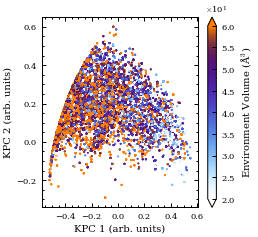

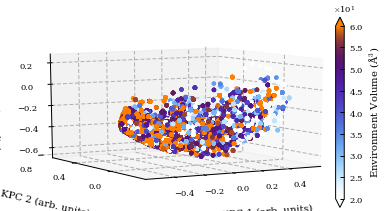

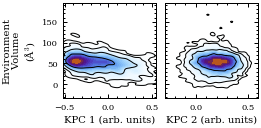

In [14]:
# Load DEEM 1k PCA (3.5 A SOAP cutoff) and structure volumes
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')
volumes = np.loadtxt('../Processed_Data/DEEM_1k/Volume/3.5/envProperties.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=volumes, cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, alpha=1.0, vmin=20, vmax=60)

axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Custom formatting of colorbar ticks to use scientific notation
formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

# Build the colorbar
CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
txt = CB.ax.yaxis.get_offset_text()
CB.ax.minorticks_off()

# Set colorbar label size and text alignment
txt.set_va('bottom')
txt.set_ha('center')

# Colorbar label
CB.set_label(ur'Environment Volume (\u00c5$^3$)')

figPCA.savefig('../Results/DEEM_1k/kpca-DEEM_volumes_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=volumes, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=20, vmax=60)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label(ur'Environment Volume (\u00c5$^3$)')

fig3D.savefig('../Results/DEEM_1k/kpca-DEEM_volumes_3.5_3D.pdf', bbox_inches='tight')

### Volume Correlation ###
figVol = plt.figure(figsize=(3.5, 1.75))
axsVol1 = figVol.add_subplot(1, 2, 1)
axsVol2 = figVol.add_subplot(1, 2, 2)

x1 = np.linspace(pcaDEEM[:, 0].min(), pcaDEEM[:, 0].max(), 100)
x2 = np.linspace(pcaDEEM[:, 1].min(), pcaDEEM[:, 1].max(), 100)
y = np.linspace(volumes.min(), volumes.max(), 100)

xx1, yy1 = np.meshgrid(x1, y)
xx2, yy2 = np.meshgrid(x2, y)
pos1 = np.vstack([xx1.ravel(), yy1.ravel()])
pos2 = np.vstack([xx2.ravel(), yy2.ravel()])

kde1 = gaussian_kde(np.vstack([pcaDEEM[:, 0], volumes]))
kde2 = gaussian_kde(np.vstack([pcaDEEM[:, 1], volumes]))

zz1 = np.reshape(kde1(pos1).T, xx1.shape)
zz2 = np.reshape(kde2(pos2).T, xx2.shape)

levels1f = np.logspace(-3, np.log10(zz1.max()), 50)
levels2f = np.logspace(-3, np.log10(zz2.max()), 50)

levels1 = np.logspace(-3, np.log10(zz1.max()), 5)
levels2 = np.logspace(-3, np.log10(zz2.max()), 5)

axsVol1.contourf(xx1, yy1, zz1, levels=levels1f)
axsVol2.contourf(xx2, yy2, zz2, levels=levels2f)
#axsVol1.scatter(pcaDEEM[:, 0], volumes, c='#aa0000', alpha=0.05)
#axsVol2.scatter(-pcaDEEM[:, 1], volumes, c='#000080', alpha=0.05)
axsVol1.contour(xx1, yy1, zz1, levels=levels1, colors='k')
axsVol2.contour(xx2, yy2, zz2, levels=levels2, colors='k')
axsVol1.set_xlabel('KPC 1 (arb. units)')
axsVol2.set_xlabel('KPC 2 (arb. units)')
axsVol1.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$)')
axsVol2.yaxis.set_ticklabels([])
figVol.subplots_adjust(wspace=0.1)

figVol.savefig('../Results/DEEM_1k/kpca-vol_3.5.pdf', bbox_inches='tight')

plt.show()

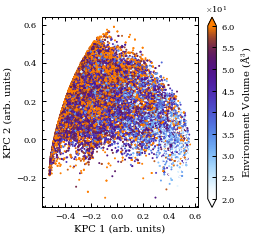

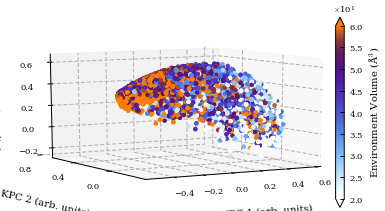

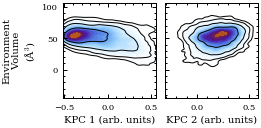

In [8]:
# Load DEEM 10k PCA (3.5 A SOAP cutoff) and structure volumes
nEnv = 505461 # Number of Si environments in DEEM 10k dataset
nPlot = 50000 # Number of Si environments to plot
nBatch = 10 # Number of batches for DEEM data
randomIdxs = np.arange(0, nEnv)
np.random.shuffle(randomIdxs)
plotIdxs = randomIdxs[0:nPlot]

n = 0
pcaDEEM = []
for i in range(0, nBatch):
    ipcaDEEM = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    subIdxs = np.intersect1d(plotIdxs[np.where(plotIdxs >= n)],
                            plotIdxs[np.where(plotIdxs < (n+len(ipcaDEEM)))]) - n
    n += len(ipcaDEEM)
    pcaDEEM.append(ipcaDEEM[subIdxs])
pcaDEEM = np.concatenate(pcaDEEM)
plotIdxs.sort()

volumes = np.loadtxt('../Processed_Data/DEEM_10k/Volume/3.5/envProperties.dat')[plotIdxs]

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=volumes, cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=20, vmax=60)

axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

# Custom formatting of colorbar ticks to use scientific notation
formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

# Build the colorbar
CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
txt = CB.ax.yaxis.get_offset_text()
CB.ax.minorticks_off()

# Set colorbar label size and text alignment
txt.set_va('bottom')
txt.set_ha('center')

# Colorbar label
CB.set_label(ur'Environment Volume (\u00c5$^3$)')

figPCA.savefig('../Results/DEEM_10k/kpca-DEEM_volumes_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=volumes, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=20, vmax=60)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label(ur'Environment Volume (\u00c5$^3$)')

fig3D.savefig('../Results/DEEM_10k/kpca-DEEM_volumes_3.5_3D.pdf', bbox_inches='tight')

### Volume Correlation ###
figVol = plt.figure(figsize=(3.5, 1.75))
axsVol1 = figVol.add_subplot(1, 2, 1)
axsVol2 = figVol.add_subplot(1, 2, 2)

x1 = np.linspace(pcaDEEM[:, 0].min(), pcaDEEM[:, 0].max(), 100)
x2 = np.linspace(pcaDEEM[:, 1].min(), pcaDEEM[:, 1].max(), 100)
y = np.linspace(volumes.min(), volumes.max(), 100)

xx1, yy1 = np.meshgrid(x1, y)
xx2, yy2 = np.meshgrid(x2, y)
pos1 = np.vstack([xx1.ravel(), yy1.ravel()])
pos2 = np.vstack([xx2.ravel(), yy2.ravel()])

kde1 = gaussian_kde(np.vstack([pcaDEEM[:, 0], volumes]))
kde2 = gaussian_kde(np.vstack([pcaDEEM[:, 1], volumes]))

zz1 = np.reshape(kde1(pos1).T, xx1.shape)
zz2 = np.reshape(kde2(pos2).T, xx2.shape)

levels1f = np.logspace(-3, np.log10(zz1.max()), 50)
levels2f = np.logspace(-3, np.log10(zz2.max()), 50)

levels1 = np.logspace(-3, np.log10(zz1.max()), 5)
levels2 = np.logspace(-3, np.log10(zz2.max()), 5)

axsVol1.contourf(xx1, yy1, zz1, levels=levels1f)
axsVol2.contourf(xx2, yy2, zz2, levels=levels2f)
#axsVol1.scatter(pcaDEEM[:, 0], volumes, c='#aa0000', alpha=0.05)
#axsVol2.scatter(-pcaDEEM[:, 1], volumes, c='#000080', alpha=0.05)
axsVol1.contour(xx1, yy1, zz1, levels=levels1, colors='k')
axsVol2.contour(xx2, yy2, zz2, levels=levels2, colors='k')
axsVol1.set_xlabel('KPC 1 (arb. units)')
axsVol2.set_xlabel('KPC 2 (arb. units)')
axsVol1.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$)')
axsVol2.yaxis.set_ticklabels([])
figVol.subplots_adjust(wspace=0.1)

figVol.savefig('../Results/DEEM_10k/kpca-vol_3.5.pdf', bbox_inches='tight')

plt.show()

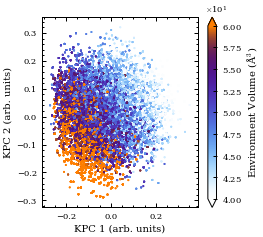

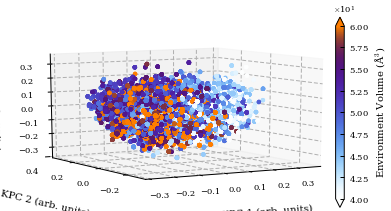

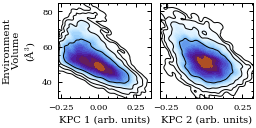

In [15]:
# Load DEEM 1k PCA (6.0 A SOAP cutoff) and structure volumes
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')
volumes = np.loadtxt('../Processed_Data/DEEM_1k/Volume/6.0/envProperties.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=volumes, cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=40, vmax=60)
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB.set_label(ur'Environment Volume (\u00c5$^3$)')

figPCA.savefig('../Results/DEEM_1k/kpca-DEEM_volumes_6.0.pdf', bbox_inches='tight')
plt.show()

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=volumes, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=40, vmax=60)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label(ur'Environment Volume (\u00c5$^3$)')

fig3D.savefig('../Results/DEEM_1k/kpca-DEEM_volumes_6.0_3D.pdf', bbox_inches='tight')

### Volume Correlation ###
figVol = plt.figure(figsize=(3.5, 1.75))
axsVol1 = figVol.add_subplot(1, 2, 1)
axsVol2 = figVol.add_subplot(1, 2, 2)

x1 = np.linspace(pcaDEEM[:, 0].min(), pcaDEEM[:, 0].max(), 100)
x2 = np.linspace(pcaDEEM[:, 1].min(), pcaDEEM[:, 1].max(), 100)
y = np.linspace(volumes.min(), volumes.max(), 100)

xx1, yy1 = np.meshgrid(x1, y)
xx2, yy2 = np.meshgrid(x2, y)
pos1 = np.vstack([xx1.ravel(), yy1.ravel()])
pos2 = np.vstack([xx2.ravel(), yy2.ravel()])

kde1 = gaussian_kde(np.vstack([pcaDEEM[:, 0], volumes]))
kde2 = gaussian_kde(np.vstack([pcaDEEM[:, 1], volumes]))

zz1 = np.reshape(kde1(pos1).T, xx1.shape)
zz2 = np.reshape(kde2(pos2).T, xx2.shape)

levels1f = np.logspace(-3, np.log10(zz1.max()), 50)
levels2f = np.logspace(-3, np.log10(zz2.max()), 50)

levels1 = np.logspace(-3, np.log10(zz1.max()), 5)
levels2 = np.logspace(-3, np.log10(zz2.max()), 5)

axsVol1.contourf(xx1, yy1, zz1, levels=levels1f)
axsVol2.contourf(xx2, yy2, zz2, levels=levels2f)
#axsVol1.scatter(-pcaDEEM[:, 0], volumes, c='#aa0000', alpha=0.1)
#axsVol2.scatter(pcaDEEM[:, 1], volumes, c='#000080', alpha=0.1)
axsVol1.contour(xx1, yy1, zz1, levels=levels1, colors='k')
axsVol2.contour(xx2, yy2, zz2, levels=levels2, colors='k')
axsVol1.set_xlabel('KPC 1 (arb. units)')
axsVol2.set_xlabel('KPC 2 (arb. units)')
axsVol1.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$)')
axsVol2.yaxis.set_ticklabels([])
figVol.subplots_adjust(wspace=0.1)

figVol.savefig('../Results/DEEM_1k/kpca-vol_6.0.pdf', bbox_inches='tight')

[316189 255982 356569 ... 313241 299846 163018]


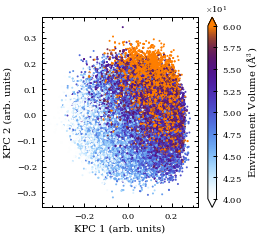

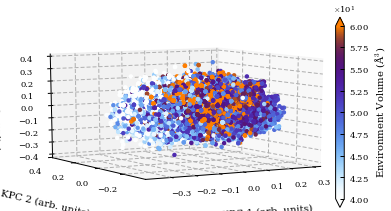

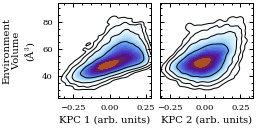

In [9]:
# Load DEEM 10k PCA (6.0 A SOAP cutoff) and structure volumes
nEnv = 505461 # Number of Si environments in DEEM 10k dataset
nPlot = 50000 # Number of Si environments to plot
nBatch = 10 # Number of batches for DEEM data
randomIdxs = np.arange(0, nEnv)
np.random.shuffle(randomIdxs)
plotIdxs = randomIdxs[0:nPlot]

print plotIdxs
n = 0
pcaDEEM = []
for i in range(0, nBatch):
    ipcaDEEM = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    subIdxs = np.intersect1d(plotIdxs[np.where(plotIdxs >= n)],
                            plotIdxs[np.where(plotIdxs < (n+len(ipcaDEEM)))]) - n
    n += len(ipcaDEEM)
    pcaDEEM.append(ipcaDEEM[subIdxs])
pcaDEEM = np.concatenate(pcaDEEM)
plotIdxs.sort()

volumes = np.loadtxt('../Processed_Data/DEEM_10k/Volume/6.0/envProperties.dat')[plotIdxs]

#pcaDEEM = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-4.npy')
#volumes = np.loadtxt('../Processed_Data/DEEM_10k/Volume/6.0/envProperties-4.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=volumes, cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=40, vmax=60)
axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB.set_label(ur'Environment Volume (\u00c5$^3$)')

figPCA.savefig('../Results/DEEM_10k/kpca-DEEM_volumes_6.0.pdf', bbox_inches='tight')
plt.show()

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=volumes, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=40, vmax=60)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label(ur'Environment Volume (\u00c5$^3$)')

fig3D.savefig('../Results/DEEM_10k/kpca-DEEM_volumes_6.0_3D.pdf', bbox_inches='tight')

### Volume Correlation ###
figVol = plt.figure(figsize=(3.5, 1.75))
axsVol1 = figVol.add_subplot(1, 2, 1)
axsVol2 = figVol.add_subplot(1, 2, 2)

x1 = np.linspace(pcaDEEM[:, 0].min(), pcaDEEM[:, 0].max(), 100)
x2 = np.linspace(pcaDEEM[:, 1].min(), pcaDEEM[:, 1].max(), 100)
y = np.linspace(volumes.min(), volumes.max(), 100)

xx1, yy1 = np.meshgrid(x1, y)
xx2, yy2 = np.meshgrid(x2, y)
pos1 = np.vstack([xx1.ravel(), yy1.ravel()])
pos2 = np.vstack([xx2.ravel(), yy2.ravel()])

kde1 = gaussian_kde(np.vstack([pcaDEEM[:, 0], volumes]))
kde2 = gaussian_kde(np.vstack([pcaDEEM[:, 1], volumes]))

zz1 = np.reshape(kde1(pos1).T, xx1.shape)
zz2 = np.reshape(kde2(pos2).T, xx2.shape)

levels1f = np.logspace(-3, np.log10(zz1.max()), 50)
levels2f = np.logspace(-3, np.log10(zz2.max()), 50)

levels1 = np.logspace(-3, np.log10(zz1.max()), 5)
levels2 = np.logspace(-3, np.log10(zz2.max()), 5)

axsVol1.contourf(xx1, yy1, zz1, levels=levels1f)
axsVol2.contourf(xx2, yy2, zz2, levels=levels2f)
#axsVol1.scatter(-pcaDEEM[:, 0], volumes, c='#aa0000', alpha=0.1)
#axsVol2.scatter(pcaDEEM[:, 1], volumes, c='#000080', alpha=0.1)
axsVol1.contour(xx1, yy1, zz1, levels=levels1, colors='k')
axsVol2.contour(xx2, yy2, zz2, levels=levels2, colors='k')
axsVol1.set_xlabel('KPC 1 (arb. units)')
axsVol2.set_xlabel('KPC 2 (arb. units)')
axsVol1.set_ylabel('Environment\nVolume\n' + ur'(\u00c5$^3$)')
axsVol2.yaxis.set_ticklabels([])
figVol.subplots_adjust(wspace=0.1)

figVol.savefig('../Results/DEEM_10k/kpca-vol_6.0.pdf', bbox_inches='tight')

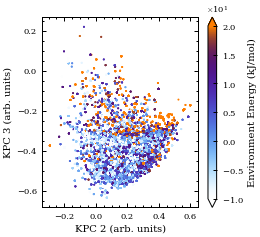

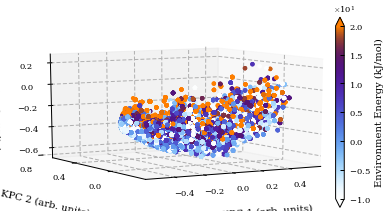

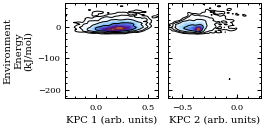

In [16]:
# Load DEEM PCA (3.5 A SOAP cutoff) and structure energies
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')
energies = np.loadtxt('../Processed_Data/DEEM_1k/Energy/3.5/envProperties.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 1], pcaDEEM[:, 2], c=energies, cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=-10, vmax=20)

axsScat.set_xlabel('KPC 2 (arb. units)')
axsScat.set_ylabel('KPC 3 (arb. units)')

# Custom formatting of colorbar ticks to use scientific notation
formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

# Build the colorbar
CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()

# Set colorbar label size and text alignment
txt.set_va('bottom')
txt.set_ha('center')

# Colorbar label
CB.set_label('Environment Energy (kJ/mol)')

figPCA.savefig('../Results/DEEM_1k/kpca-DEEM_energies_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=energies, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=-10, vmax=20)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label('Environment Energy (kJ/mol)')

fig3D.savefig('../Results/DEEM_1k/kpca-DEEM_energies_3.5_3D.pdf', bbox_inches='tight')

### Energy Correlation ###
figE = plt.figure(figsize=(3.5, 1.75))
axsE1 = figE.add_subplot(1, 2, 1)
axsE2 = figE.add_subplot(1, 2, 2)

x1 = np.linspace(pcaDEEM[:, 1].min(), pcaDEEM[:, 1].max(), 100)
x2 = np.linspace(pcaDEEM[:, 2].min(), pcaDEEM[:, 2].max(), 100)
y = np.linspace(energies.min(), energies.max(), 100)

xx1, yy1 = np.meshgrid(x1, y)
xx2, yy2 = np.meshgrid(x2, y)
pos1 = np.vstack([xx1.ravel(), yy1.ravel()])
pos2 = np.vstack([xx2.ravel(), yy2.ravel()])

kde1 = gaussian_kde(np.vstack([pcaDEEM[:, 1], energies]))
kde2 = gaussian_kde(np.vstack([pcaDEEM[:, 2], energies]))

zz1 = np.reshape(kde1(pos1).T, xx1.shape)
zz2 = np.reshape(kde2(pos2).T, xx2.shape)

levels1f = np.logspace(-3, np.log10(zz1.max()), 50)
levels2f = np.logspace(-3, np.log10(zz2.max()), 50)

levels1 = np.logspace(-3, np.log10(zz1.max()), 5)
levels2 = np.logspace(-3, np.log10(zz2.max()), 5)

axsE1.contourf(xx1, yy1, zz1, levels=levels1f)
axsE2.contourf(xx2, yy2, zz2, levels=levels2f)
#axsE1.scatter(pcaDEEM[:, 0], energies, c='#aa0000', alpha=0.1)
#axsE2.scatter(-pcaDEEM[:, 1], energies, c='#000080', alpha=0.1)
axsE1.contour(xx1, yy1, zz1, levels=levels1, colors='k')
axsE2.contour(xx2, yy2, zz2, levels=levels2, colors='k')
axsE1.set_xlabel('KPC 1 (arb. units)')
axsE2.set_xlabel('KPC 2 (arb. units)')
axsE1.set_ylabel('Environment\nEnergy\n(kJ/mol)')
axsE2.yaxis.set_ticklabels([])
figE.subplots_adjust(wspace=0.1)

figE.savefig('../Results/DEEM_1k/kpca-energy_3.5.pdf', bbox_inches='tight')

plt.show()

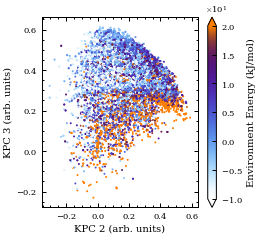

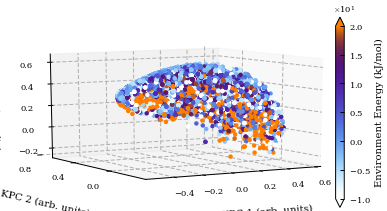

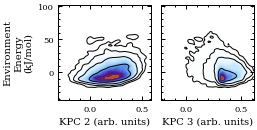

In [12]:
# Load DEEM PCA (3.5 A SOAP cutoff) and structure energies
# Load DEEM 10k PCA (6.0 A SOAP cutoff) and structure volumes
nEnv = 505461 # Number of Si environments in DEEM 10k dataset
nPlot = 50000 # Number of Si environments to plot
nBatch = 10 # Number of batches for DEEM data
randomIdxs = np.arange(0, nEnv)
np.random.shuffle(randomIdxs)
plotIdxs = randomIdxs[0:nPlot]

n = 0
pcaDEEM = []
for i in range(0, nBatch):
    ipcaDEEM = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    subIdxs = np.intersect1d(plotIdxs[np.where(plotIdxs >= n)],
                            plotIdxs[np.where(plotIdxs < (n+len(ipcaDEEM)))]) - n
    n += len(ipcaDEEM)
    pcaDEEM.append(ipcaDEEM[subIdxs])
pcaDEEM = np.concatenate(pcaDEEM)
plotIdxs.sort()

energies = np.loadtxt('../Processed_Data/DEEM_10k/Energy/3.5/envProperties.dat')[plotIdxs]

### 2D PCA ###
figPCA = plt.figure(figsize=(3.5, 3.5))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 1], pcaDEEM[:, 2], c=energies, cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=-10, vmax=20)

axsScat.set_xlabel('KPC 2 (arb. units)')
axsScat.set_ylabel('KPC 3 (arb. units)')

# Custom formatting of colorbar ticks to use scientific notation
formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

# Build the colorbar
CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()

# Set colorbar label size and text alignment
txt.set_va('bottom')
txt.set_ha('center')

# Colorbar label
CB.set_label('Environment Energy (kJ/mol)')

figPCA.savefig('../Results/DEEM_10k/kpca-DEEM_energies_3.5.pdf', bbox_inches='tight')

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.5))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=energies, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=-10, vmax=20)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label('Environment Energy (kJ/mol)')

fig3D.savefig('../Results/DEEM_10k/kpca-DEEM_energies_3.5_3D.pdf', bbox_inches='tight')

### Energy Correlation ###
figE = plt.figure(figsize=(3.5, 1.75))
axsE1 = figE.add_subplot(1, 2, 1)
axsE2 = figE.add_subplot(1, 2, 2)

x1 = np.linspace(pcaDEEM[:, 1].min(), pcaDEEM[:, 1].max(), 100)
x2 = np.linspace(pcaDEEM[:, 2].min(), pcaDEEM[:, 2].max(), 100)
y = np.linspace(energies.min(), energies.max(), 100)

xx1, yy1 = np.meshgrid(x1, y)
xx2, yy2 = np.meshgrid(x2, y)
pos1 = np.vstack([xx1.ravel(), yy1.ravel()])
pos2 = np.vstack([xx2.ravel(), yy2.ravel()])

kde1 = gaussian_kde(np.vstack([pcaDEEM[:, 1], energies]))
kde2 = gaussian_kde(np.vstack([pcaDEEM[:, 2], energies]))

zz1 = np.reshape(kde1(pos1).T, xx1.shape)
zz2 = np.reshape(kde2(pos2).T, xx2.shape)

levels1f = np.logspace(-3, np.log10(zz1.max()), 50)
levels2f = np.logspace(-3, np.log10(zz2.max()), 50)

levels1 = np.logspace(-3, np.log10(zz1.max()), 5)
levels2 = np.logspace(-3, np.log10(zz2.max()), 5)

axsE1.contourf(xx1, yy1, zz1, levels=levels1f)
axsE2.contourf(xx2, yy2, zz2, levels=levels2f)
#axsE1.scatter(pcaDEEM[:, 0], energies, c='#aa0000', alpha=0.1)
#axsE2.scatter(-pcaDEEM[:, 1], energies, c='#000080', alpha=0.1)
axsE1.contour(xx1, yy1, zz1, levels=levels1, colors='k')
axsE2.contour(xx2, yy2, zz2, levels=levels2, colors='k')
axsE1.set_xlabel('KPC 2 (arb. units)')
axsE2.set_xlabel('KPC 3 (arb. units)')
axsE1.set_ylabel('Environment\nEnergy\n(kJ/mol)')
axsE2.yaxis.set_ticklabels([])
figE.subplots_adjust(wspace=0.1)

figE.savefig('../Results/DEEM_10k/kpca-energy_3.5.pdf', bbox_inches='tight')

plt.show()

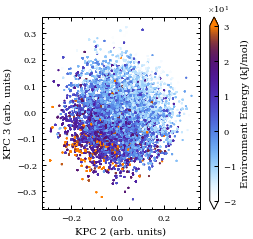

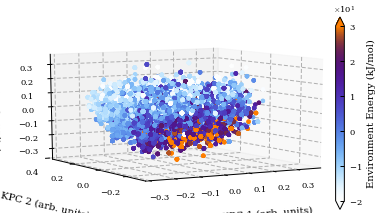

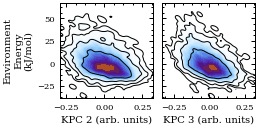

In [17]:
# Load DEEM PCA (6.0 A SOAP cutoff) and structure energies
pcaDEEM = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')
energies = np.loadtxt('../Processed_Data/DEEM_1k/Energy/6.0/envProperties.dat')

### 2D PCA ###
figPCA = plt.figure(figsize=(3.54, 3.54))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 1], pcaDEEM[:, 2], c=energies, cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=-20, vmax=30)

axsScat.set_xlabel('KPC 2 (arb. units)')
axsScat.set_ylabel('KPC 3 (arb. units)')

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB.set_label('Environment Energy (kJ/mol)')

figPCA.savefig('../Results/DEEM_1k/kpca-DEEM_energies_6.0.pdf', bbox_inches='tight')
plt.show()

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.54))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=energies, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=-20, vmax=30)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label('Environment Energy (kJ/mol)')

fig3D.savefig('../Results/DEEM_1k/kpca-DEEM_energies_6.0_3D.pdf', bbox_inches='tight')

### Energy Correlation ###
figE = plt.figure(figsize=(3.5, 1.75))
axsE1 = figE.add_subplot(1, 2, 1)
axsE2 = figE.add_subplot(1, 2, 2)

x1 = np.linspace(pcaDEEM[:, 1].min(), pcaDEEM[:, 1].max(), 100)
x2 = np.linspace(pcaDEEM[:, 2].min(), pcaDEEM[:, 2].max(), 100)
y = np.linspace(energies.min(), energies.max(), 100)

xx1, yy1 = np.meshgrid(x1, y)
xx2, yy2 = np.meshgrid(x2, y)
pos1 = np.vstack([xx1.ravel(), yy1.ravel()])
pos2 = np.vstack([xx2.ravel(), yy2.ravel()])

kde1 = gaussian_kde(np.vstack([pcaDEEM[:, 1], energies]))
kde2 = gaussian_kde(np.vstack([pcaDEEM[:, 2], energies]))

zz1 = np.reshape(kde1(pos1).T, xx1.shape)
zz2 = np.reshape(kde2(pos2).T, xx2.shape)

levels1f = np.logspace(-3, np.log10(zz1.max()), 50)
levels2f = np.logspace(-3, np.log10(zz2.max()), 50)

levels1 = np.logspace(-3, np.log10(zz1.max()), 5)
levels2 = np.logspace(-3, np.log10(zz2.max()), 5)

axsE1.contourf(xx1, yy1, zz1, levels=levels1f)
axsE2.contourf(xx2, yy2, zz2, levels=levels2f)
#axsE1.scatter(-pcaDEEM[:, 1], energies, c='#aa0000', alpha=0.1)
#axsE2.scatter(-pcaDEEM[:, 2], energies, c='#000080', alpha=0.1)
axsE1.contour(xx1, yy1, zz1, levels=levels1, colors='k')
axsE2.contour(xx2, yy2, zz2, levels=levels2, colors='k')
axsE1.set_xlabel('KPC 2 (arb. units)')
axsE2.set_xlabel('KPC 3 (arb. units)')
axsE1.set_ylabel('Environment\nEnergy\n(kJ/mol)')
axsE2.yaxis.set_ticklabels([])
figE.subplots_adjust(wspace=0.1)

figE.savefig('../Results/DEEM_1k/kpca-energy_6.0.pdf', bbox_inches='tight')

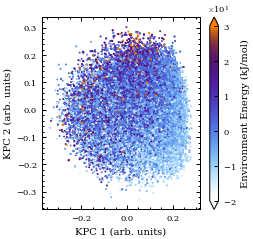

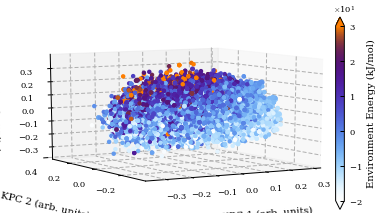

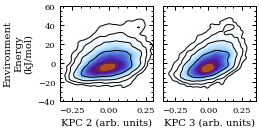

In [2]:
# Load DEEM PCA (6.0 A SOAP cutoff) and structure energies
# Load DEEM PCA (3.5 A SOAP cutoff) and structure energies
# Load DEEM 10k PCA (6.0 A SOAP cutoff) and structure volumes
nEnv = 505461 # Number of Si environments in DEEM 10k dataset
nPlot = 50000 # Number of Si environments to plot
nBatch = 10 # Number of batches for DEEM data
randomIdxs = np.arange(0, nEnv)
np.random.shuffle(randomIdxs)
plotIdxs = randomIdxs[0:nPlot]

n = 0
pcaDEEM = []
for i in range(0, nBatch):
    ipcaDEEM = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    subIdxs = np.intersect1d(plotIdxs[np.where(plotIdxs >= n)],
                            plotIdxs[np.where(plotIdxs < (n+len(ipcaDEEM)))]) - n
    n += len(ipcaDEEM)
    pcaDEEM.append(ipcaDEEM[subIdxs])
pcaDEEM = np.concatenate(pcaDEEM)
plotIdxs.sort()

energies = np.loadtxt('../Processed_Data/DEEM_10k/Energy/6.0/envProperties.dat')[plotIdxs]

### 2D PCA ###
figPCA = plt.figure(figsize=(3.54, 3.54))
axsScat = figPCA.add_subplot(1, 1, 1)

scatDEEM = axsScat.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], c=energies, cmap=plt.get_cmap('cbarHot'), 
                           edgecolor='k', linewidths=0.0, alpha=1.0, vmin=-20, vmax=30)

axsScat.set_xlabel('KPC 1 (arb. units)')
axsScat.set_ylabel('KPC 2 (arb. units)')

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB = figPCA.colorbar(scatDEEM, ax=axsScat, format=formatter, extend='both')
CB.ax.minorticks_off()
txt = CB.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB.set_label('Environment Energy (kJ/mol)')

figPCA.savefig('../Results/DEEM_10k/kpca-DEEM_energies_6.0.pdf', bbox_inches='tight')
plt.show()

### 3D PCA ###
fig3D = plt.figure(figsize=(7.0, 3.54))
axs3D = fig3D.add_subplot(1, 1, 1, projection='3d')

scatDEEM3D = axs3D.scatter(pcaDEEM[:, 0], pcaDEEM[:, 1], pcaDEEM[:, 2], c=energies, 
                           cmap=plt.get_cmap('cbarHot'), edgecolor='k', linewidths=0.0, 
                           alpha=1.0, vmin=-20, vmax=30)
axs3D.set_xlabel('KPC 1 (arb. units)', labelpad=20)
axs3D.set_ylabel('KPC 2 (arb. units)', labelpad=20)
axs3D.set_zlabel('KPC 3 (arb. units)', labelpad=10)
axs3D.set_yticks(axs3D.get_yticks()[2::2])
axs3D.view_init(10, -120)

formatter = mpltkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))

CB3D = fig3D.colorbar(scatDEEM3D, ax=axs3D, format=formatter, pad=-0.05, extend='both')
CB3D.ax.minorticks_off()
txt = CB3D.ax.yaxis.get_offset_text()
txt.set_va('bottom')
txt.set_ha('center')
CB3D.set_label('Environment Energy (kJ/mol)')

fig3D.savefig('../Results/DEEM_10k/kpca-DEEM_energies_6.0_3D.pdf', bbox_inches='tight')

### Energy Correlation ###
figE = plt.figure(figsize=(3.5, 1.75))
axsE1 = figE.add_subplot(1, 2, 1)
axsE2 = figE.add_subplot(1, 2, 2)

x1 = np.linspace(pcaDEEM[:, 1].min(), pcaDEEM[:, 1].max(), 100)
x2 = np.linspace(pcaDEEM[:, 2].min(), pcaDEEM[:, 2].max(), 100)
y = np.linspace(energies.min(), energies.max(), 100)

xx1, yy1 = np.meshgrid(x1, y)
xx2, yy2 = np.meshgrid(x2, y)
pos1 = np.vstack([xx1.ravel(), yy1.ravel()])
pos2 = np.vstack([xx2.ravel(), yy2.ravel()])

kde1 = gaussian_kde(np.vstack([pcaDEEM[:, 1], energies]))
kde2 = gaussian_kde(np.vstack([pcaDEEM[:, 2], energies]))

zz1 = np.reshape(kde1(pos1).T, xx1.shape)
zz2 = np.reshape(kde2(pos2).T, xx2.shape)

levels1f = np.logspace(-3, np.log10(zz1.max()), 50)
levels2f = np.logspace(-3, np.log10(zz2.max()), 50)

levels1 = np.logspace(-3, np.log10(zz1.max()), 5)
levels2 = np.logspace(-3, np.log10(zz2.max()), 5)

axsE1.contourf(xx1, yy1, zz1, levels=levels1f)
axsE2.contourf(xx2, yy2, zz2, levels=levels2f)
#axsE1.scatter(-pcaDEEM[:, 1], energies, c='#aa0000', alpha=0.1)
#axsE2.scatter(-pcaDEEM[:, 2], energies, c='#000080', alpha=0.1)
axsE1.contour(xx1, yy1, zz1, levels=levels1, colors='k')
axsE2.contour(xx2, yy2, zz2, levels=levels2, colors='k')
axsE1.set_xlabel('KPC 2 (arb. units)')
axsE2.set_xlabel('KPC 3 (arb. units)')
axsE1.set_ylabel('Environment\nEnergy\n(kJ/mol)')
axsE2.yaxis.set_ticklabels([])
figE.subplots_adjust(wspace=0.1)

# WARNING: OUTLIERS!
axsE1.set_ylim(-40, 60)
axsE2.set_ylim(-40, 60)

figE.savefig('../Results/DEEM_10k/kpca-energy_6.0.pdf', bbox_inches='tight')

# PDFs and Distance Metrics

In [ ]:
# Load DEEM and IZA histograms, 3.5 A SOAP cutoff
histDEEM = ReadPDF('../Processed_Data/DEEM_1k/PCA/3.5/DEEM.ndhist')
histIZA = ReadPDF('../Processed_Data/IZA_DEEM_1k/PCA/3.5/IZA_DEEM.ndhist')

### 2D Histograms ###
figPDF = plt.figure(figsize=(3.54, 3.54))
axsPDF = figPDF.add_subplot(1, 1, 1)

# Number of contour levels
nLvls = 50

# Build array of colors with varying alpha values
# so that the histogram plot will be more opaque
# in regions of higher density and more transparent
# in regions of lower density
colorConvert = mplcolors.ColorConverter()
colorListName = [colorList[5], colorList[1]]
colorListRGBA = np.asarray([colorConvert.to_rgba(c) for c in colorListName])
colorListAlpha = []

lvlsDEEM = np.logspace(0, np.log10(histDEEM[2].max()), nLvls)
lvlsIZA = np.logspace(0, np.log10(histIZA[2].max()), nLvls)
alphas = np.linspace(0.0, 0.75, nLvls)

for i in range(0, len(colorListRGBA)):
    colorListAlpha.append([colorListRGBA[i].copy() for a in alphas])
    for j in range(0, nLvls):
        colorListAlpha[i][j][3] = alphas[j]
        
# Filled contour plots of IZA and DEEM with varying transparency at each level
contourDEEM = axsPDF.contourf(histDEEM[0], histDEEM[1], histDEEM[2], levels=lvlsDEEM, colors=colorListAlpha[0], antialiased=True)
contourIZA = axsPDF.contourf(histIZA[0], histIZA[1], histIZA[2], levels=lvlsIZA, colors=colorListAlpha[1], antialiased=True)

axsPDF.set_xlabel('PC 1 (arb. units)')
axsPDF.set_ylabel('PC 2 (arb. units)')

# Custom legend design
legendPatches = []
for j in range(0, len(colorListName)):
    legendPatches.append(mplpatches.Patch(facecolor=colorListName[j], edgecolor='k', linewidth=0.0, alpha=0.5))

axsPDF.legend(handles=legendPatches, labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False)

figPDF.savefig('../Results/DEEM_1k/pdfs_3.5.pdf', bbox_inches='tight')
plt.show()

In [ ]:
### Distance metrics for 2D PCA with 3.5 A SOAP cutoff ###

# KL Divergence: DKL(DEEM||IZA) and DKL(IZA||DEEM)
KL_DI = KullbackLieblerDivergence(histDEEM.data, histIZA.data)
KL_ID = KullbackLieblerDivergence(histIZA.data, histDEEM.data)
print "KL Divergence: ", KL_DI, KL_ID

# JS Divergence: DJS(DEEM||IZA) and DJS(IZA||DEEM)
JS_DI = JensenShannonDivergence(histDEEM.data, histIZA.data)
JS_ID = JensenShannonDivergence(histIZA.data, histDEEM.data)
print "JS Divergence: ", JS_DI, JS_ID

# Bhattacharyya Coefficient and Distance: DB(DEEM||IZA) and DB(IZA||DEEM)
BC_DI, BD_DI = BhattacharyyaDistance(histDEEM.data, histIZA.data)
BC_ID, BD_ID = BhattacharyyaDistance(histIZA.data, histDEEM.data)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

# Density and Bin Overlap: OVP(DEEM||IZA) and OVP(IZA||DEEM)
overlap_DI, overlapBins_D = BinOverlap(histDEEM.data, histIZA.data)
overlap_ID, overlapBins_I = BinOverlap(histIZA.data, histDEEM.data)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

# Integral Overlap: OVP(DEEM||IZA) and OVP(IZA||DEEM)
intOverlap_DI = IntegralOverlap(histDEEM.data, histIZA.data)
intOverlap_ID = IntegralOverlap(histIZA.data, histDEEM.data)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Probability of guessing the DB correctly
Guessing_DB = ProbabilityofGuessingCorrectlyDB(histIZA.data, histDEEM.data)
print "Probability of Guessing the DB: ", Guessing_DB

In [ ]:
### Distance metrics for 3D PCA with 3.5 A SOAP cutoff ###

# Load histograms and reshape so that they can be used
# in the various distance metric functions
histDEEM3D = np.loadtxt('../Processed_Data/DEEM_1k/PCA/3.5/DEEM3D.ndhist', unpack=True)
xPts = len(np.unique(histDEEM3D[0]))
yPts = len(np.unique(histDEEM3D[1]))
zPts = len(np.unique(histDEEM3D[2]))
histDEEM3D = np.reshape(histDEEM3D, (4, xPts, yPts, zPts))

histIZA3D = np.loadtxt('../Processed_Data/IZA_DEEM_1k/PCA/3.5/IZA_DEEM3D.ndhist', unpack=True)
xPts = len(np.unique(histIZA3D[0]))
yPts = len(np.unique(histIZA3D[1]))
zPts = len(np.unique(histIZA3D[2]))
histIZA3D = np.reshape(histIZA3D, (4, xPts, yPts, zPts))

KL_DI = KullbackLieblerDivergence(histDEEM3D, histIZA3D)
KL_ID = KullbackLieblerDivergence(histIZA3D, histDEEM3D)
print "KL Divergence: ", KL_DI, KL_ID

JS_DI = JensenShannonDivergence(histDEEM3D, histIZA3D)
JS_ID = JensenShannonDivergence(histIZA3D, histDEEM3D)
print "JS Divergence: ", JS_DI, JS_ID

BC_DI, BD_DI = BhattacharyyaDistance(histDEEM3D, histIZA3D)
BC_ID, BD_ID = BhattacharyyaDistance(histIZA3D, histDEEM3D)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

overlap_DI, overlapBins_D = BinOverlap(histDEEM3D, histIZA3D)
overlap_ID, overlapBins_I = BinOverlap(histIZA3D, histDEEM3D)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

intOverlap_DI = IntegralOverlap(histDEEM3D, histIZA3D)
intOverlap_ID = IntegralOverlap(histIZA3D, histDEEM3D)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Probability of guessing the DB correctly
Guessing_DB = ProbabilityofGuessingCorrectlyDB(histIZA3D, histDEEM3D)
print "Probability of Guessing the DB: ", Guessing_DB

In [ ]:
# Load DEEM and IZA histograms, 6.0 A SOAP cutoff
histDEEM = ReadPDF('../Processed_Data/DEEM_1k/PCA/6.0/DEEM.ndhist')
histIZA = ReadPDF('../Processed_Data/IZA_DEEM_1k/PCA/6.0/IZA_DEEM.ndhist')

### 2D Histograms ###
figPDF = plt.figure(figsize=(3.54, 3.54))
axsPDF = figPDF.add_subplot(1, 1, 1)
nLvls = 50

colorConvert = mplcolors.ColorConverter()
colorListName = [colorList[5], colorList[1]]
colorListRGBA = np.asarray([colorConvert.to_rgba(c) for c in colorListName])
colorListAlpha = []

lvlsDEEM = np.logspace(0, np.log10(histDEEM[2].max()), nLvls)
lvlsIZA = np.logspace(0, np.log10(histIZA[2].max()), nLvls)
alphas = np.linspace(0.0, 0.75, nLvls)

for i in range(0, len(colorListRGBA)):
    colorListAlpha.append([colorListRGBA[i].copy() for a in alphas])
    for j in range(0, nLvls):
        colorListAlpha[i][j][3] = alphas[j]
        
contourDEEM = axsPDF.contourf(histDEEM[0], histDEEM[1], histDEEM[2], levels=lvlsDEEM, colors=colorListAlpha[0], antialiased=True)
contourIZA = axsPDF.contourf(histIZA[0], histIZA[1], histIZA[2], levels=lvlsIZA, colors=colorListAlpha[1], antialiased=True)

axsPDF.set_xlabel('PC 1 (arb. units)')
axsPDF.set_ylabel('PC 2 (arb. units)')

legendPatches = []
for j in range(0, len(colorListName)):
    legendPatches.append(mplpatches.Patch(facecolor=colorListName[j], edgecolor='k', linewidth=0.0, alpha=0.5))

axsPDF.legend(handles=legendPatches, labels=['DEEM', 'IZA projected\non DEEM PC'], frameon=False)

figPDF.savefig('../Results/DEEM_1k/pdfs_6.0.pdf', bbox_inches='tight')
plt.show()

In [ ]:
### Distance metrics for 2D PCA with 6.0 A SOAP cutoff ###

# Compute distance metrics as above
KL_DI = KullbackLieblerDivergence(histDEEM.data, histIZA.data)
KL_ID = KullbackLieblerDivergence(histIZA.data, histDEEM.data)
print "KL Divergence: ", KL_DI, KL_ID

JS_DI = JensenShannonDivergence(histDEEM.data, histIZA.data)
JS_ID = JensenShannonDivergence(histIZA.data, histDEEM.data)
print "JS Divergence: ", JS_DI, JS_ID

BC_DI, BD_DI = BhattacharyyaDistance(histDEEM.data, histIZA.data)
BC_ID, BD_ID = BhattacharyyaDistance(histIZA.data, histDEEM.data)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

overlap_DI, overlapBins_D = BinOverlap(histDEEM.data, histIZA.data)
overlap_ID, overlapBins_I = BinOverlap(histIZA.data, histDEEM.data)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

intOverlap_DI = IntegralOverlap(histDEEM.data, histIZA.data)
intOverlap_ID = IntegralOverlap(histIZA.data, histDEEM.data)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Probability of guessing the DB correctly
Guessing_DB = ProbabilityofGuessingCorrectlyDB(histIZA.data, histDEEM.data)
print "Probability of Guessing the DB: ", Guessing_DB

In [ ]:
### Distance metrics for 3D PCA with 6.0 A SOAP cutoff ###

# Load histograms and reshape so that they can be used
# in the various distance metric functions
histDEEM3D = np.loadtxt('../Processed_Data/DEEM_1k/PCA/6.0/DEEM3D.ndhist', unpack=True)
xPts = len(np.unique(histDEEM3D[0]))
yPts = len(np.unique(histDEEM3D[1]))
zPts = len(np.unique(histDEEM3D[2]))
histDEEM3D = np.reshape(histDEEM3D, (4, xPts, yPts, zPts))

histIZA3D = np.loadtxt('../Processed_Data/IZA_DEEM_1k/PCA/6.0/IZA_DEEM3D.ndhist', unpack=True)
xPts = len(np.unique(histIZA3D[0]))
yPts = len(np.unique(histIZA3D[1]))
zPts = len(np.unique(histIZA3D[2]))
histIZA3D = np.reshape(histIZA3D, (4, xPts, yPts, zPts))

# Compute distance metrics, as above
KL_DI = KullbackLieblerDivergence(histDEEM3D, histIZA3D)
KL_ID = KullbackLieblerDivergence(histIZA3D, histDEEM3D)
print "KL Divergence: ", KL_DI, KL_ID

JS_DI = JensenShannonDivergence(histDEEM3D, histIZA3D)
JS_ID = JensenShannonDivergence(histIZA3D, histDEEM3D)
print "JS Divergence: ", JS_DI, JS_ID

BC_DI, BD_DI = BhattacharyyaDistance(histDEEM3D, histIZA3D)
BC_ID, BD_ID = BhattacharyyaDistance(histIZA3D, histDEEM3D)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

overlap_DI, overlapBins_D = BinOverlap(histDEEM3D, histIZA3D)
overlap_ID, overlapBins_I = BinOverlap(histIZA3D, histDEEM3D)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

intOverlap_DI = IntegralOverlap(histDEEM3D, histIZA3D)
intOverlap_ID = IntegralOverlap(histIZA3D, histDEEM3D)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Probability of guessing the DB correctly
Guessing_DB = ProbabilityofGuessingCorrectlyDB(histIZA3D, histDEEM3D)
print "Probability of Guessing the DB: ", Guessing_DB

In [ ]:
### Distance metrics for Rings ###

# Load histograms and reshape so that they can be used
# in the various distance metric functions
DEEM_kings = np.transpose(np.loadtxt('../Processed_Data/Rings/DEEM_Kings.hist'))
DEEM_short = np.transpose(np.loadtxt('../Processed_Data/Rings/DEEM_Short.hist'))
IZA_kings = np.transpose(np.loadtxt('../Processed_Data/Rings/IZA_Kings.hist'))
IZA_short = np.transpose(np.loadtxt('../Processed_Data/Rings/IZA_Short.hist'))

# Compare Kings and Short ring methods for DEEM
print "=== DEEM Kings vs DEEM Short ==="
KL_DI = KullbackLieblerDivergence(DEEM_kings, DEEM_short)
KL_ID = KullbackLieblerDivergence(DEEM_short, DEEM_kings)
print "KL Divergence: ", KL_DI, KL_ID

JS_DI = JensenShannonDivergence(DEEM_kings, DEEM_short)
JS_ID = JensenShannonDivergence(DEEM_short, DEEM_kings)
print "JS Divergence: ", JS_DI, JS_ID

BC_DI, BD_DI = BhattacharyyaDistance(DEEM_kings, DEEM_short)
BC_ID, BD_ID = BhattacharyyaDistance(DEEM_short, DEEM_kings)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

overlap_DI, overlapBins_D = BinOverlap(DEEM_kings, DEEM_short)
overlap_ID, overlapBins_I = BinOverlap(DEEM_short, DEEM_kings)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

intOverlap_DI = IntegralOverlap(DEEM_kings, DEEM_short)
intOverlap_ID = IntegralOverlap(DEEM_short, DEEM_kings)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Compare Kings and Short ring methods for IZA
print "\n=== IZA Kings vs IZA Short ==="
KL_DI = KullbackLieblerDivergence(IZA_kings, IZA_short)
KL_ID = KullbackLieblerDivergence(IZA_short, IZA_kings)
print "KL Divergence: ", KL_DI, KL_ID

JS_DI = JensenShannonDivergence(IZA_kings, IZA_short)
JS_ID = JensenShannonDivergence(IZA_short, IZA_kings)
print "JS Divergence: ", JS_DI, JS_ID

BC_DI, BD_DI = BhattacharyyaDistance(IZA_kings, IZA_short)
BC_ID, BD_ID = BhattacharyyaDistance(IZA_short, IZA_kings)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

overlap_DI, overlapBins_D = BinOverlap(IZA_kings, IZA_short)
overlap_ID, overlapBins_I = BinOverlap(IZA_short, IZA_kings)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

intOverlap_DI = IntegralOverlap(IZA_kings, IZA_short)
intOverlap_ID = IntegralOverlap(IZA_short, IZA_kings)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Compare DEEM and IZA with King ring method
print "\n=== DEEM Kings vs IZA Kings ==="
KL_DI = KullbackLieblerDivergence(DEEM_kings, IZA_kings)
KL_ID = KullbackLieblerDivergence(IZA_kings, DEEM_kings)
print "KL Divergence: ", KL_DI, KL_ID

JS_DI = JensenShannonDivergence(DEEM_kings, IZA_kings)
JS_ID = JensenShannonDivergence(IZA_kings, DEEM_kings)
print "JS Divergence: ", JS_DI, JS_ID

BC_DI, BD_DI = BhattacharyyaDistance(DEEM_kings, IZA_kings)
BC_ID, BD_ID = BhattacharyyaDistance(IZA_kings, DEEM_kings)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

overlap_DI, overlapBins_D = BinOverlap(DEEM_kings, IZA_kings)
overlap_ID, overlapBins_I = BinOverlap(IZA_kings, DEEM_kings)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

intOverlap_DI = IntegralOverlap(DEEM_kings, IZA_kings)
intOverlap_ID = IntegralOverlap(IZA_kings, DEEM_kings)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Probability of guessing the DB correctly
Guessing_DB = ProbabilityofGuessingCorrectlyDB(IZA_kings, DEEM_kings)
print "Probability of Guessing the DB: ", Guessing_DB

# Compare DEEM and IZA with Short ring method
print "\n=== DEEM Short vs IZA Short ==="
KL_DI = KullbackLieblerDivergence(DEEM_short, IZA_short)
KL_ID = KullbackLieblerDivergence(IZA_short, DEEM_short)
print "KL Divergence: ", KL_DI, KL_ID

JS_DI = JensenShannonDivergence(DEEM_short, IZA_short)
JS_ID = JensenShannonDivergence(IZA_short, DEEM_short)
print "JS Divergence: ", JS_DI, JS_ID

BC_DI, BD_DI = BhattacharyyaDistance(DEEM_short, IZA_short)
BC_ID, BD_ID = BhattacharyyaDistance(IZA_short, DEEM_short)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

overlap_DI, overlapBins_D = BinOverlap(DEEM_short, IZA_short)
overlap_ID, overlapBins_I = BinOverlap(IZA_short, DEEM_short)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

intOverlap_DI = IntegralOverlap(DEEM_short, IZA_short)
intOverlap_ID = IntegralOverlap(IZA_short, DEEM_short)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Probability of guessing the DB correctly
Guessing_DB = ProbabilityofGuessingCorrectlyDB(IZA_short, DEEM_short)
print "Probability of Guessing the DB: ", Guessing_DB

In [ ]:
### Distance metrics for Si-O-Si Angles ###

# Load histograms and reshape so that they can be used
# in the various distance metric functions
DEEM_angles = np.transpose(np.loadtxt('../Processed_Data/Angles/Angles_DEEM.hist')[:, 0:-1])
IZA_angles = np.transpose(np.loadtxt('../Processed_Data/Angles/Angles_IZA.hist')[:, 0:-1])

KL_DI = KullbackLieblerDivergence(DEEM_angles, IZA_angles)
KL_ID = KullbackLieblerDivergence(IZA_angles, DEEM_angles)
print "KL Divergence: ", KL_DI, KL_ID

JS_DI = JensenShannonDivergence(DEEM_angles, IZA_angles)
JS_ID = JensenShannonDivergence(IZA_angles, DEEM_angles)
print "JS Divergence: ", JS_DI, JS_ID

BC_DI, BD_DI = BhattacharyyaDistance(DEEM_angles, IZA_angles)
BC_ID, BD_ID = BhattacharyyaDistance(IZA_angles, DEEM_angles)
print "Bhattacharyya Coefficient: ", BC_DI, BC_ID
print "Bhattacharyya Distance: ", BD_DI, BD_ID

overlap_DI, overlapBins_D = BinOverlap(DEEM_angles, IZA_angles)
overlap_ID, overlapBins_I = BinOverlap(IZA_angles, DEEM_angles)
print "Bin Overlap: ", overlapBins_D, overlapBins_I
print "Density Overlap: ", overlap_DI, overlap_ID

intOverlap_DI = IntegralOverlap(DEEM_angles, IZA_angles)
intOverlap_ID = IntegralOverlap(IZA_angles, DEEM_angles)
print "Integral Overlap: ", intOverlap_DI, intOverlap_ID

# Probability of guessing the DB correctly
Guessing_DB = ProbabilityofGuessingCorrectlyDB(IZA_angles, DEEM_angles)
print "Probability of Guessing the DB: ", Guessing_DB